In [3]:
%load_ext autoreload
%autoreload 2
import pickle as pkl
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
import sklearn.metrics
import viz
from tqdm import tqdm

import config
import util
from config import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# loading

In [4]:
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))

annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
N = len(config.ATTRS)

**orthogonalize**

In [5]:
# fit each linear model
np.random.seed(13)
models = []
for r in tqdm(range(N)):
    attr = config.ATTRS[r]
    y = annotations_dict[attr].mean(axis=1)
    y = (y - y.mean()) / (y.std())
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        latents, y, test_size=0.3, random_state=42)
    m = sklearn.linear_model.RidgeCV(alphas=np.logspace(-2, 4, num=20))
    m.fit(X_train, y_train)
    models.append(deepcopy(m))

100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


In [6]:
intercepts = [model.intercept_.flatten()
        for model in models]

In [8]:
vecs = [model.coef_.flatten()
        for model in models]
# vecs_orth = {}
vecs_orth = util.orthogonalize_paper(np.array(vecs).transpose())

# also put them into a dict
vecs_orth_dict = {
    attr: vecs_orth[:, i] for i, attr in enumerate(ATTRS)
}

vecs_orig_arr = np.array(vecs)
vecs_orth_arr = vecs_orth.transpose() # np.array([vecs_orth[k] for k in vecs_orth])
sims_orig = sklearn.metrics.pairwise.cosine_similarity(vecs_orig_arr)
sims_orth = sklearn.metrics.pairwise.cosine_similarity(vecs_orth_arr)

In [9]:
pkl.dump({'vecs_orth': vecs_orth_arr,
          'intercepts': intercepts},
         open(oj(config.PROCESSED_DIR, '04_orth.pkl'), 'wb'))

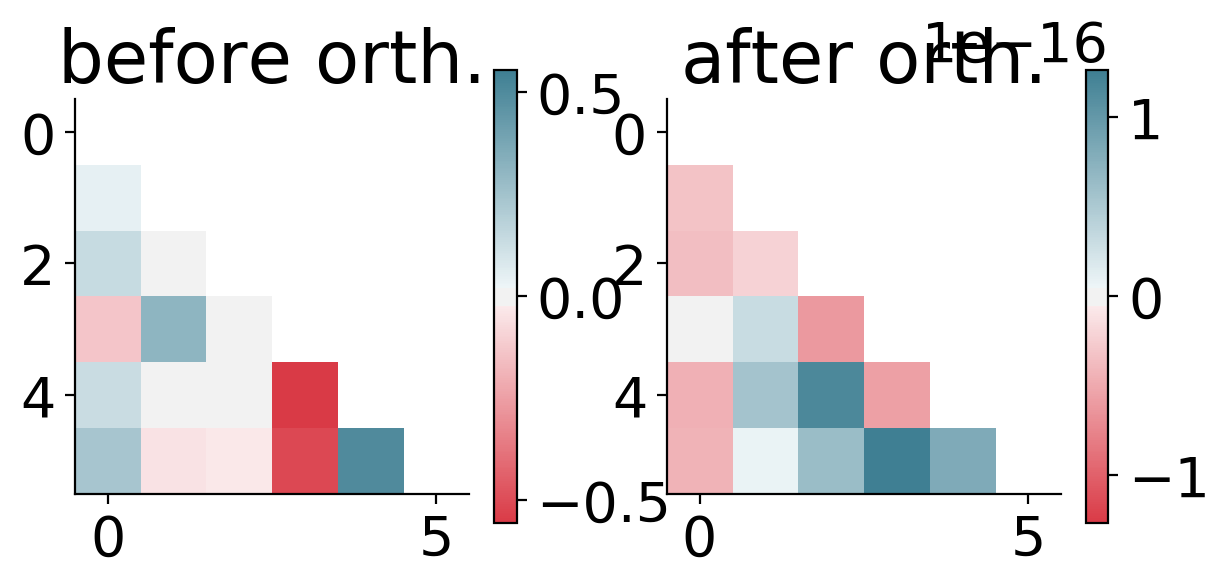

In [10]:
mask = np.triu(np.ones_like(sims_orig, dtype=np.bool))
plt.figure(dpi=200, figsize=(7, 3))
plt.subplot(121)
plt.title('before orth.')
viz.corrplot(sims_orig)
plt.colorbar()

plt.subplot(122)
plt.title('after orth.')
viz.corrplot(sims_orth)
plt.colorbar()
plt.show()

# fitting better linear models

6it [00:01,  3.16it/s]
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


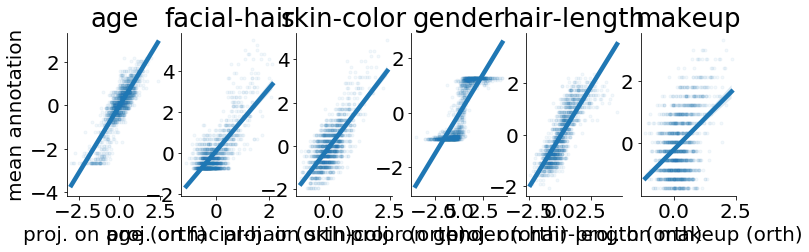

In [12]:
X = latents
R = 1
C = N
plt.figure(figsize=(C * 2, 3))
for i, attr in tqdm(enumerate(ATTRS)):
    attr_to_proj = attr
    y = annotations_dict[attr].mean(axis=1)
    y = (y - y.mean()) / (y.std())
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=0.3, random_state=42)
    direction = vecs_orth_dict[attr]
    projections = X_test @ direction + intercepts[i] # m.predict(X_test)
    
    plt.subplot(R, C, i + 1)
    plt.title(attr)
    sns.regplot(projections, y_test, marker='.', scatter_kws={'alpha': 0.05})
    
    if i == 0:
        plt.ylabel('mean annotation')
    plt.xlabel(f'proj. on {attr_to_proj} (orth)')
#     plt.xlabel('projection onto linear direction')
#     plt.plot(projections, mean_attr, '.')
plt.tight_layout()

**how independent are they**

100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


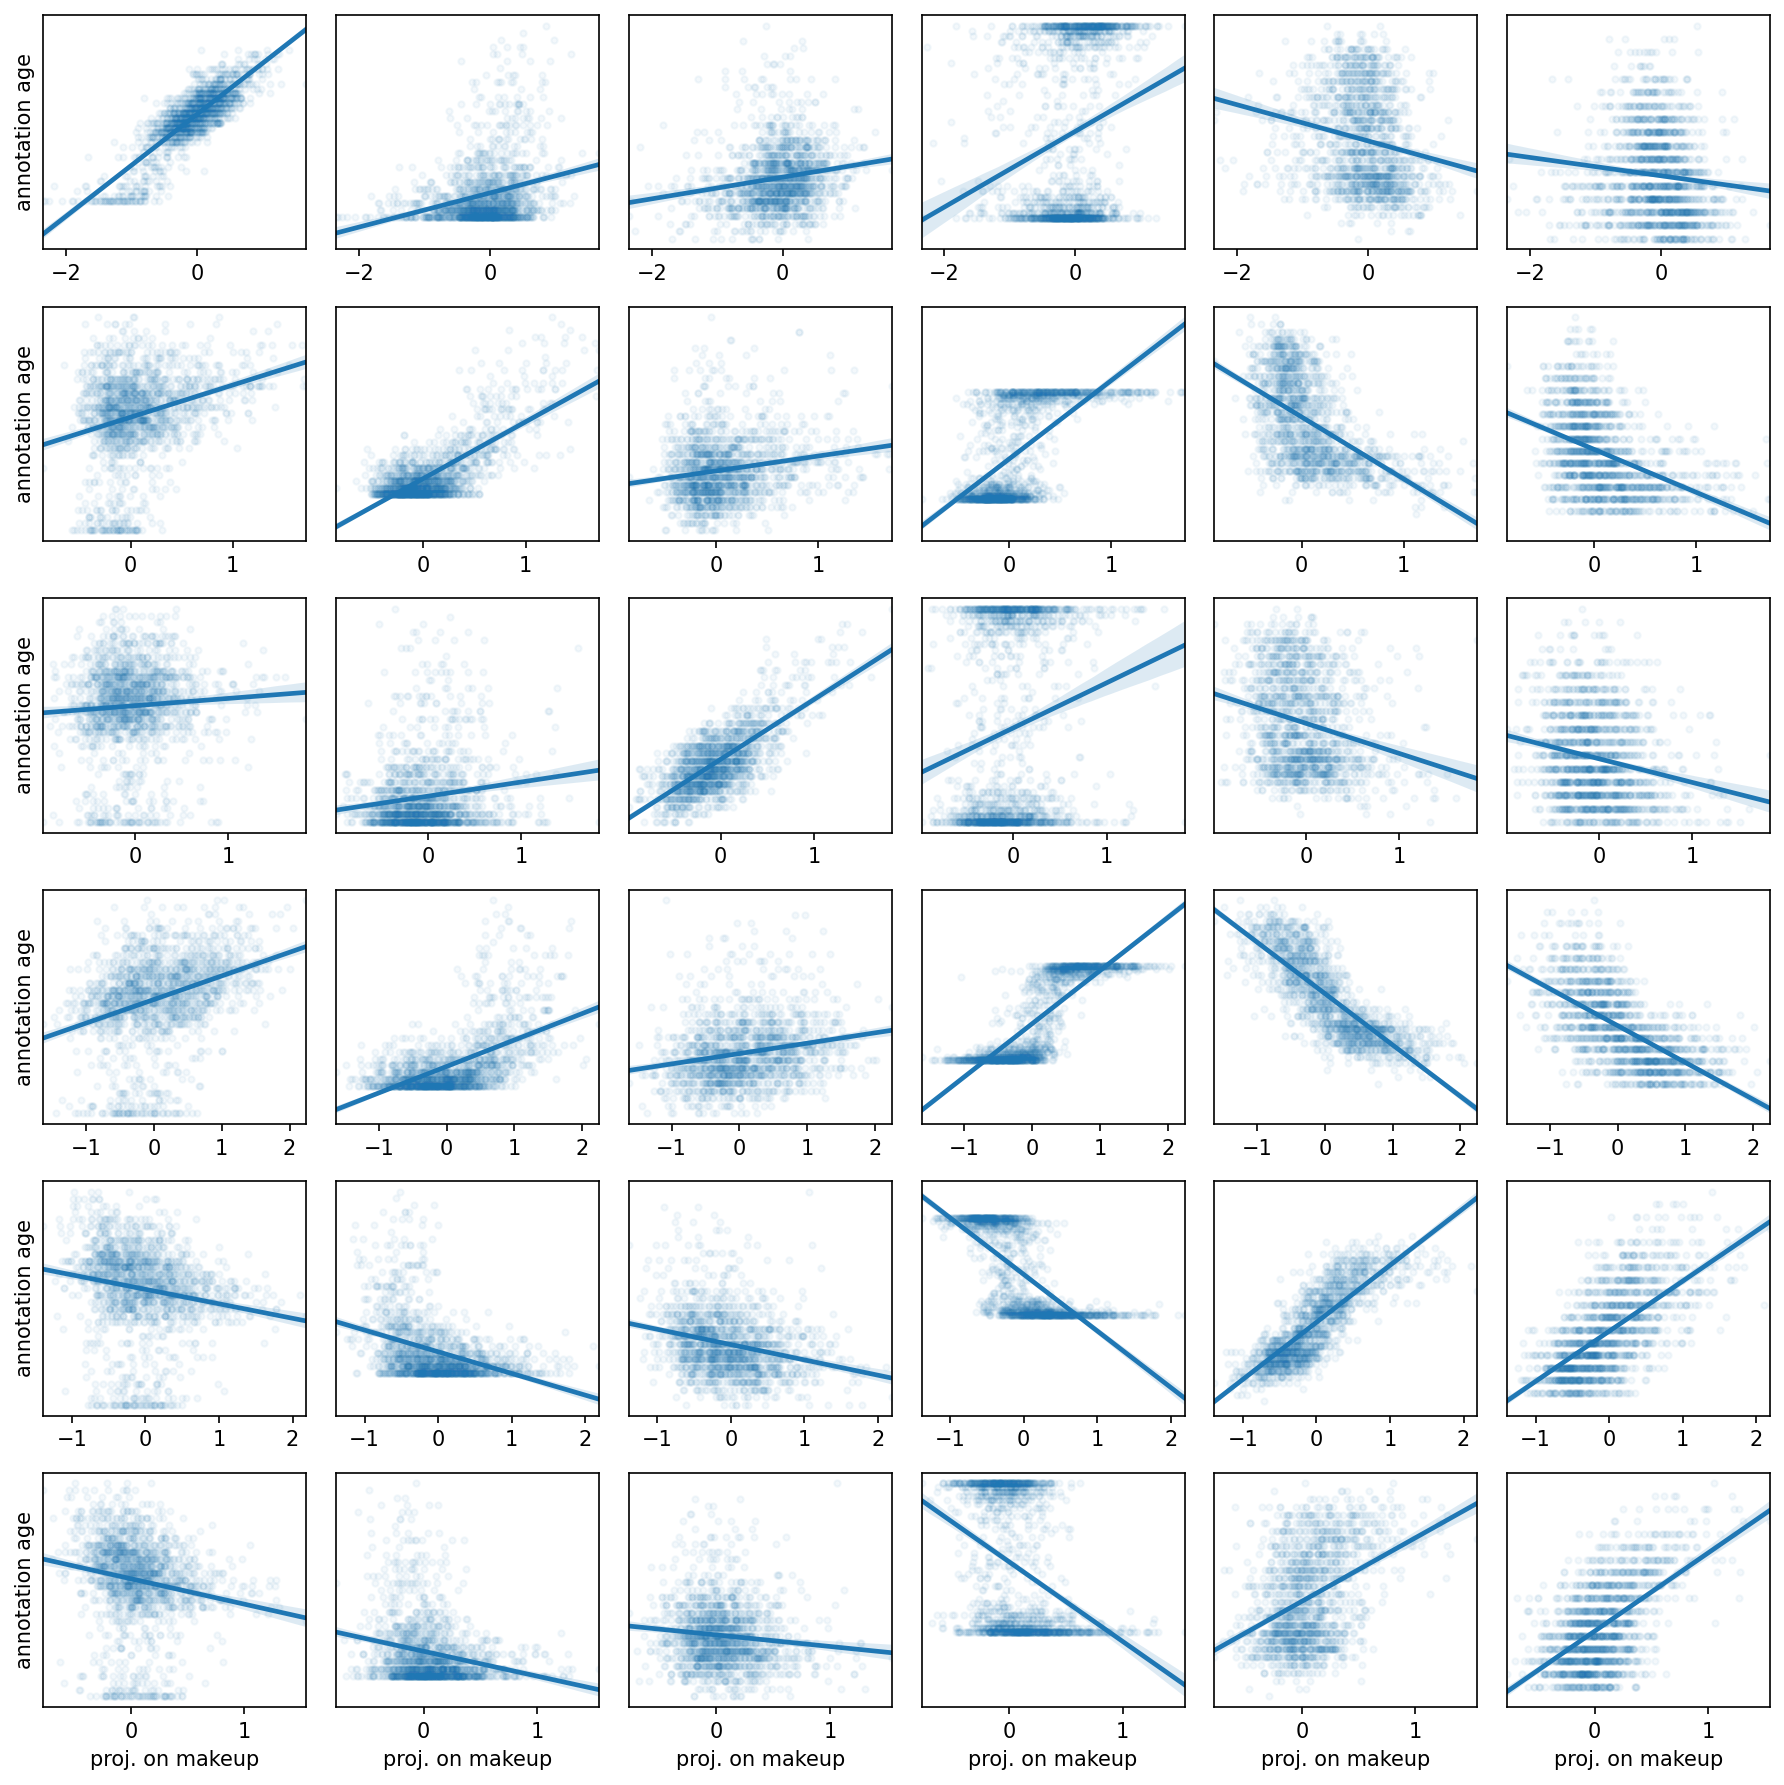

In [37]:
R, C = N, N
N = len(attrs)
spearman_mat = np.zeros((N, N))
mse_mat = np.zeros((N, N))
inter_attribute_corrs_mat = np.zeros((N, N))
i = 0
plt.figure(figsize=(12, 12), dpi=150)
for r in tqdm(range(N)):
    attr = attrs[r]
    # m = sklearn.linear_model.RidgeCV()
    y = annotations_dict[attr].mean(axis=1)
    y = (y - y.mean()) / (y.std())
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=0.3, random_state=42)
#     m = pkl.load(open(oj(PROCESSED_DIR, f'02_m_{attr}.pkl'), 'rb'))
    # m.fit(X_train, y_train)
    direction = vecs_orth_dict[attr]
#     projections = X_test @ direction # m.predict(X_test)
    
    for c in range(N):
        attr_test = attrs[c]
        projections = X_test @ direction
        y = annotations_dict[attr_test].mean(axis=1)
        y = (y - y.mean()) / (y.std())
        y_train, y_test = sklearn.model_selection.train_test_split(
            y, test_size=0.3, random_state=42)  
        

        plt.subplot(R, C, i + 1)
#         if r == 0:
#             plt.title('measure ' + attr_test)
        if c == 0:
            plt.ylabel(f'annotation {attr_test}')
        
        sns.regplot(projections, y_test, marker='.', scatter_kws={'alpha': 0.05})
        spearman_mat[r, c] = scipy.stats.spearmanr(projections, y_test).correlation# np.corrcoef(projections, y_test)[0, 1]
        mse_mat[r, c] = np.mean(np.square(projections - y_test))
        inter_attribute_corrs_mat[r, c] = np.corrcoef(projections, X_test @ vecs_orth_dict[attrs[c]])[0, 1]
        plt.yticks([])
        if r == N - 1:
            plt.xlabel('proj. on ' + attr)
        i += 1
plt.tight_layout() 

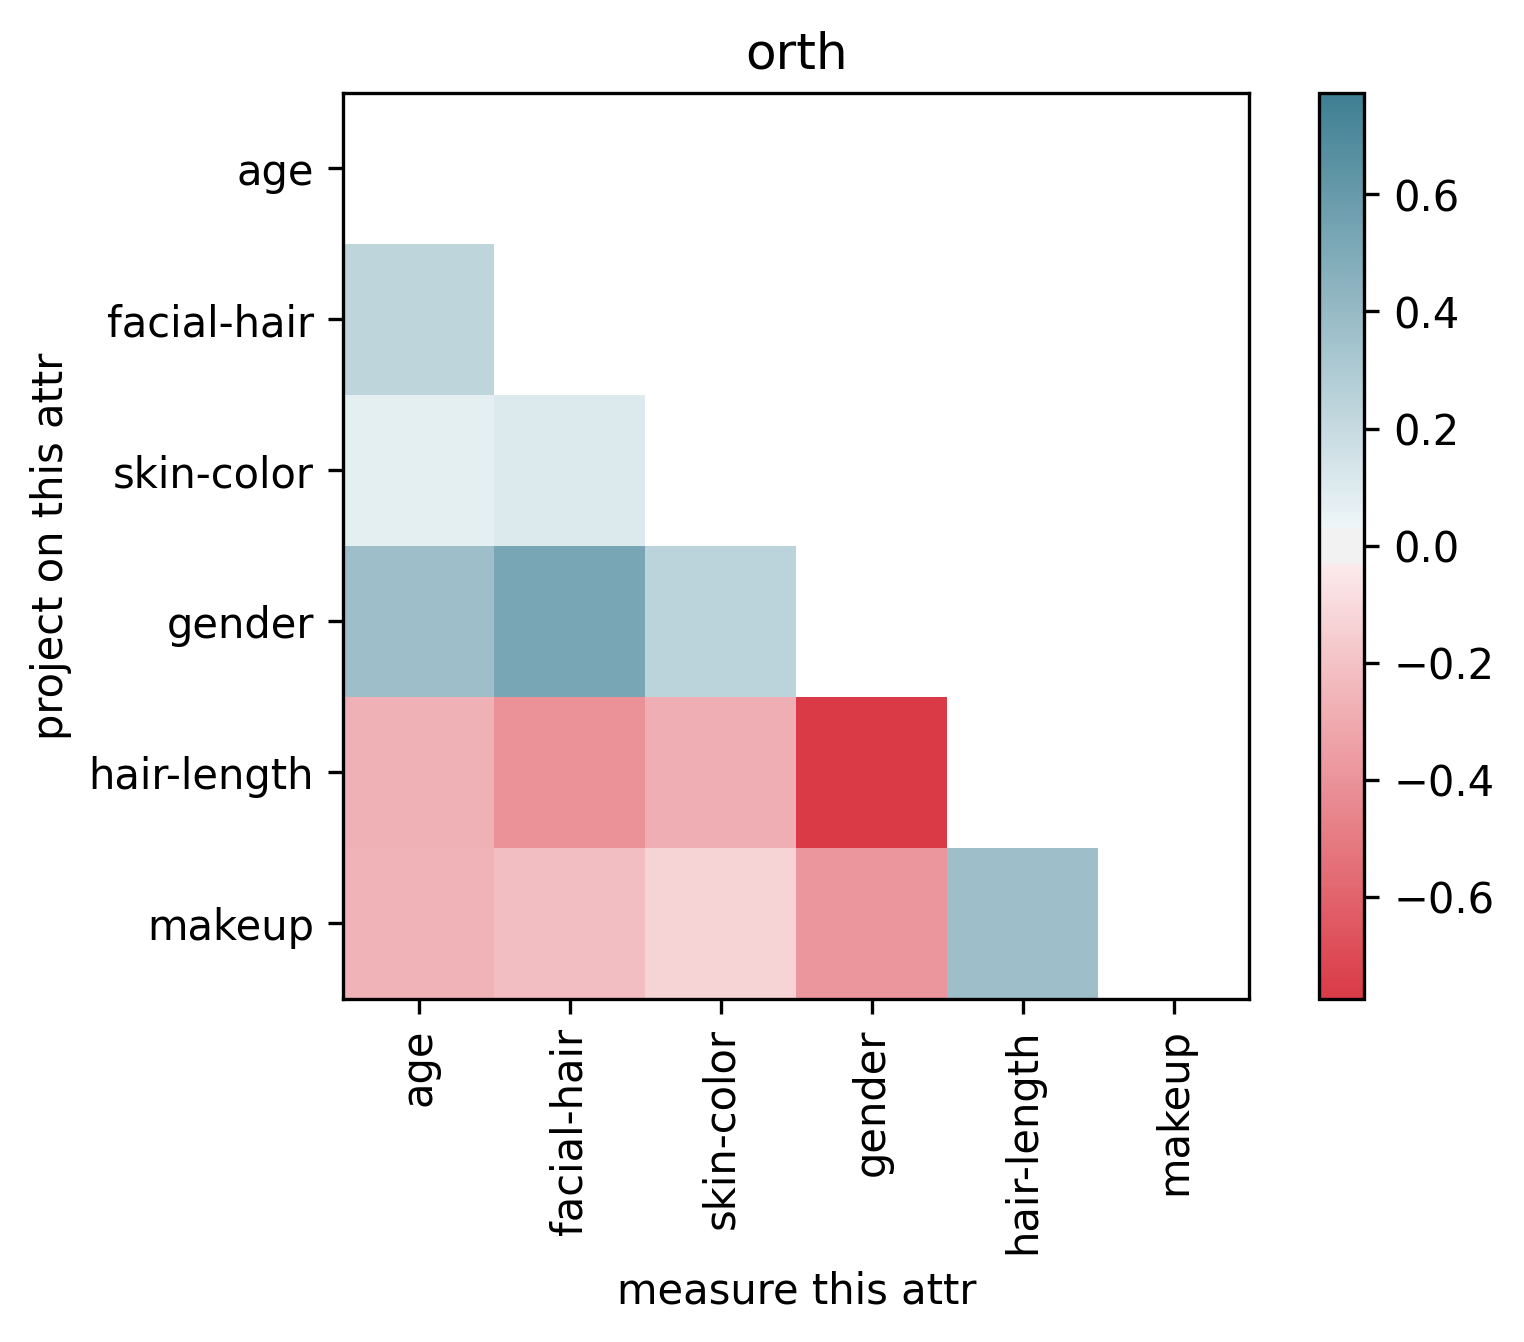

In [38]:
plt.figure(dpi=300)
viz.corrplot(spearman_mat)
plt.title('orth')
plt.xticks(range(N), attrs, rotation='vertical')
plt.ylabel('project on this attr')
plt.xlabel('measure this attr')
plt.yticks(range(N), attrs)
plt.colorbar()
plt.show()

In [44]:
print('summary statistcs for test data')
print('mse on test data',
      np.mean(mse_mat[np.eye(N).astype(bool)]))
print('corr between attributes on test data',
      np.mean(np.abs(inter_attribute_corrs_mat[~np.eye(N).astype(bool)])))

summary statistcs for test data
mse on test data 0.5153266844179131
corr between attributes on test data 0.3401953866334223
